# Sky model tutorial

User input to the sky model is required to be given in terms of astropy quantities (`astropy.unit.Quantity` objects). As such, we begin by importing astropy units.

In [7]:
import astropy.units as u

## Loading a sky model

There are two ways to initialize the Cosmoglobe Sky Model. The default way is to use the ``cosmoglobe.skymodel`` function, which by default downloads and cache a HDF5 file containing the model data (for a specific NSIDE).

Alternatively, we can use ``cosmoglobe.model_from_chain`` if we have direct access to a commander3 chain.

### Using ``cosmoglobe.skymodel`` (currently unavailable)

This method is currently unavailable as we are working on producing the first stable data release. As a result the below code will not function as of now.

In [8]:
# from cosmoglobe import skymodel
# model = skymodel(nside=256)

### Using ``cosmoglobe.model_from_chain``

This method initializes a model directly from a commander3 HDF5 chainfile.

In [9]:
from cosmoglobe import model_from_chain

# Path to commander3 chainfile
chain = "/path/to/chainfile.h5"

# Initializing the Cosmoglobe Sky Model at NSIDE 256
model = model_from_chain(chain, nside=256)

Loading components from chain
Done: 100%|██████████| 6/6 [00:05<00:00,  1.15it/s]


## The model object 

To get an overview of the model and the sky components in it, we can print the model object:

In [10]:
model

Model(
  nside: 256
  components( 
    (ame): AME(nu_p)
    (cmb): CMB()
    (dust): Dust(beta, T)
    (ff): FreeFree(Te)
    (radio): Radio(specind)
    (synch): Synchrotron(beta)
  )
)

We can disable any component in the model with the `model.disable()` function:

In [11]:
model.disable('radio')
model

Model(
  nside: 256
  components( 
    (ame): AME(nu_p)
    (cmb): CMB()
    (dust): Dust(beta, T)
    (ff): FreeFree(Te)
    (synch): Synchrotron(beta)
  )
)

And re-enable them using the `model.enable` function:

In [12]:
model.enable('radio')

## Model components

Let us explore the sky components in further detail. Each component can be individually accessed through the attribute names seen in the parentheses of the ``print(model)`` output.

In [13]:
print(model.dust)
print(model.synch)

Dust(beta, T)
Synchrotron(beta)


### Component attributes

The model data is stored in the following component attributes:

- `amp`: Amplitude map at the reference frequency (Commander average posterior map)

- `freq_ref`: Reference frequency of `amp`

- `spectral_parameters`: A dictionary containing the spectral parameters

We can print these attributes:

In [14]:
print(model.dust.amp)
print(model.dust.freq_ref)
print(model.dust.spectral_parameters)

[[30.309875   -0.4310924   8.452302   ...  6.667059    9.971937
  11.81585   ]
 [-4.019577   -1.2983557   1.6992227  ...  4.3319874  -5.6275396
   0.72578835]
 [ 2.6104844   2.118119   -0.9043058  ... -6.7324114   0.4760493
   0.7606246 ]] uK
[[545.]
 [353.]
 [353.]] GHz
{'beta': <Quantity [[1.5476462],
           [1.5766188],
           [1.5766188]]>, 'T': <Quantity [[17.331007],
           [17.331007],
           [17.331007]] K>}


### Visualizing components

The maps of a component (`amp` or a spectral parameter map) can be visualized like normal using `healpy.mollview`. 

Alternatively, we can use `cosmoglobe.plot`, which is a wrapper on healpy's mollview function that features built-in esthetique choices. 

In this tutorial we will use `cosmoglobe.plot`. For a more in in-depth overview of the built-in plot function, please see the plotting tutorial (coming soon).

In [15]:
from cosmoglobe import plot

Let us plot some of the reference amplitude maps used in the current model:

Applying semi-logscale
Colormap: sunburst


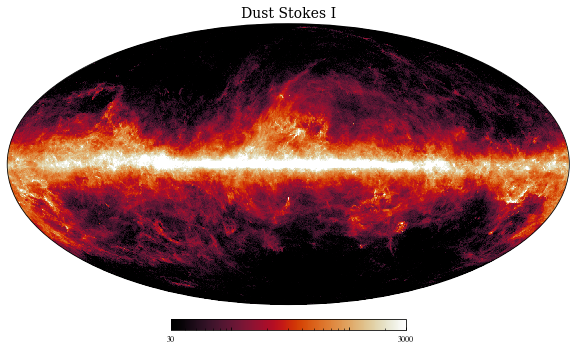

In [16]:
# Stokes I map of dust
dust_amp_I = model.dust.amp[0]

plot(
    dust_amp_I,
    title='Dust Stokes I',
    min=30,
    max=3000,
    norm='log',
    cmap='sunburst',
)

Applying semi-logscale
Colormap: iceburn


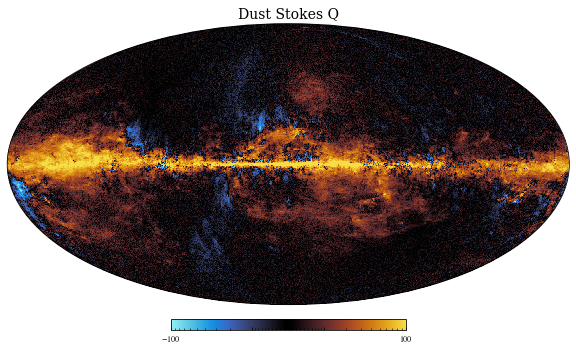

In [17]:
# Stokes Q map of dust
dust_amp_Q = model.dust.amp[1]

plot(
    dust_amp_Q,
    title='Dust Stokes Q',
    min=-100,
    max=100,
    norm='log',
    cmap='iceburn',
)

## Simulations

The primary use case of the *cosmoglobe* software is to provide the community with astrophysical maps generated with the Cosmoglobe Sky Model. The mean posterior maps used in the sky model (given at some reference frequency) are directly accessible through model attributes as demonstrated in the above section.

These maps can additionally be extrapolated to arbitrary frequencies to produce simulations of the sky. In the following we look at how we can use *cosmoglobe* to generate full sky simulations:

### Simulating component emission

We can simulate the emission from a component at an arbitrary frequency `freq` by calling the component's `__call__` method, e.g, `model.dust(freq)`.

This function takes in the following key word arguments:

- `freqs` : A frequency, or a list of frequencies for which to evaluate the sky emission

- `bandpass` : Bandpass profile corresponding to the frequencies (*optional*)

- `fwhm` : The full width half max parameter of the Gaussian used to smooth the output (optional)

- `output_unit` : The output units of the emission (By default the output unit of the model is always in uK_RJ

Below, is a simulation of synchrotron emission at $20\;\mathrm{GHz}$:

Colormap: swamp


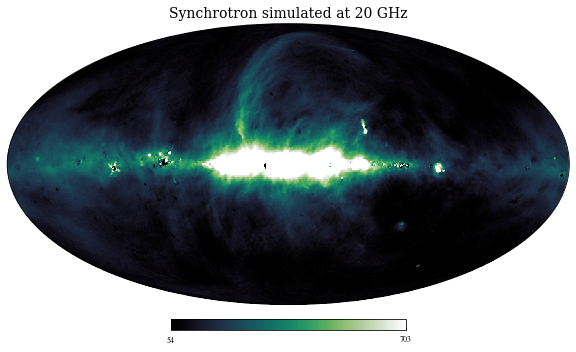

In [18]:
# Simulated synchrotron emission at 20GHz
simulated_emission = model.synch(20*u.GHz)

plot(
    simulated_emission[0],
    title='Synchrotron simulated at 20 GHz', 
    cmap='swamp',
)

And a simulation of free-free emission at $20\;\mathrm{GHz}$ with a FWHM of $30\;'$ and output units set to $\mathrm{MJy/sr}$:

Colormap: freeze


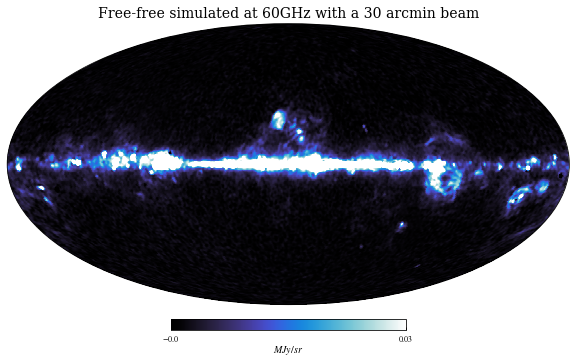

In [19]:
# Simulated free-free emission at 60GHz seen by a 30 arcmin
# beam in units of MJy/sr
simulated_emission = model.ff(
    60*u.GHz, 
    fwhm=30*u.arcmin, 
    output_unit='MJy/sr'
)

plot(
    simulated_emission[0], 
    title='Free-free simulated at 60GHz with a 30 arcmin beam', 
    unit=simulated_emission.unit,
    cmap='freeze',
)

### Simulating model emission

Similarly, by calling the model's `__call__` function (which takes in the same keyword arguments), we can simulate the sky emission over the full model at a given frequency:

100%|██████████| 12192/12192 [00:02<00:00, 4588.56it/s]
Smoothing diffuse emission
Colormap: planck


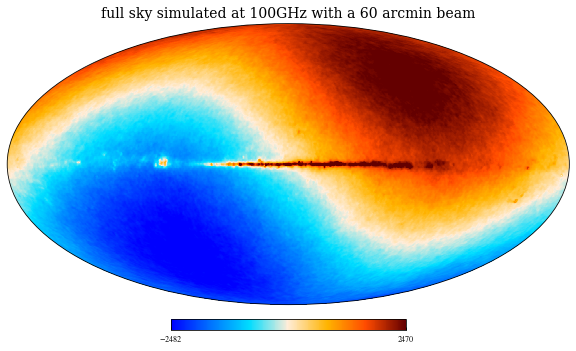

In [20]:
# Simulated full sky emission at 100GHz seen by a 60 arcmin
# beam in units of uK_RJ
simulated_emission = model(100*u.GHz, fwhm=60*u.arcmin)

plot(
    simulated_emission[0], 
    title='full sky simulated at 100GHz with a 60 arcmin beam',  
    min=-3400,
    max=3400,
    norm='hist',
)


It is possible to remove the solar dipole from the model, by calling `model.cmb.remove_dipole()`:

100%|██████████| 12192/12192 [00:02<00:00, 4327.24it/s]
Smoothing diffuse emission
Colormap: planck


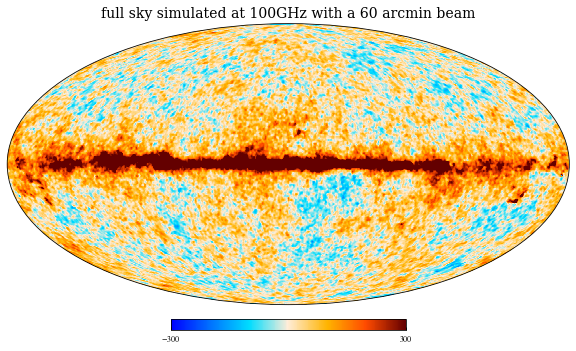

In [21]:
# Remove the solar dipole
model.cmb.remove_dipole()

# Simulated full sky emission at 100GHz seen by a 60 arcmin
# beam in units of uK_RJ
simulated_emission = model(100*u.GHz, fwhm=60*u.arcmin)

plot(
    simulated_emission[0], 
    title='full sky simulated at 100GHz with a 60 arcmin beam', 
    min=-300,
    max=300,
)


### Bandpass integration

We can also make simulations that have integrated the sky emission over a given bandpass. By default 
if only a list of frequencies are supplied without an explicit bandpass input, a top-hat bandpass will be used during the integration.

100%|██████████| 12192/12192 [00:02<00:00, 5485.50it/s]
Smoothing diffuse emission
Colormap: planck


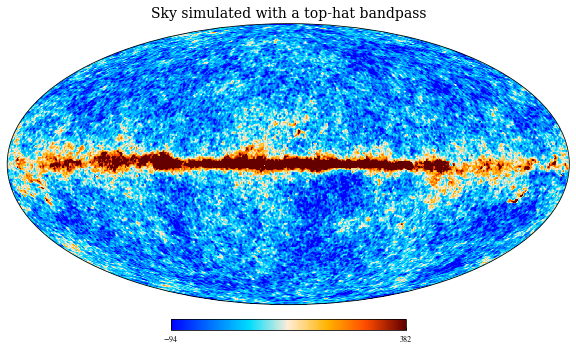

In [22]:
import numpy as np

frequencies = np.arange(100, 110, 50)*u.GHz

simulated_emission = model(frequencies, fwhm=40*u.arcmin)

plot(
    simulated_emission[0], 
    title='Sky simulated with a top-hat bandpass', 
    norm='hist',
)

In the following we use the WMAP K-band bandpass profile:

In [23]:
bandpass = "/path/to/wmap_bandpass.txt"
frequencies, bandpass, _ = np.loadtxt(bandpass, unpack=True)

#add astropy units to the bandpass
frequencies*= u.GHz
bandpass *= u.K

100%|██████████| 12192/12192 [00:02<00:00, 5127.73it/s]
Smoothing diffuse emission
Colormap: planck


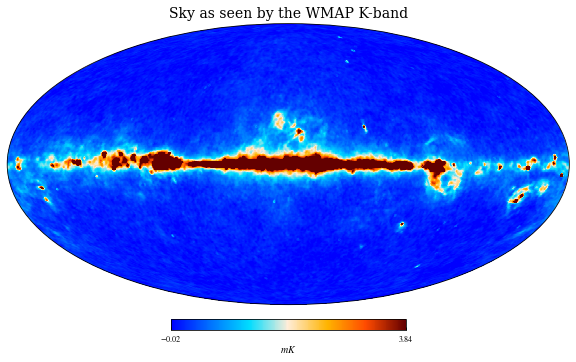

In [24]:
# Note: Solar dipole is removed from the model
wmap_kband_emission = model(
    frequencies, 
    bandpass, 
    fwhm=0.88*u.deg, 
    output_unit='mK'
)

plot(
    wmap_kband_emission[0], 
    title='Sky as seen by the WMAP K-band', 
    unit=wmap_kband_emission.unit,
    norm='hist',
)

## Point sources

The radio component does not store HEALPIX amplitude maps internally. Instead, the *amp* quantity contains a list of amplitude values, one per point source. Each source is then mapped to a HEALPIX map with a truncated gaussian beam whenever the model (or radio component) is called.

100%|██████████| 12192/12192 [00:02<00:00, 5337.73it/s]
Applying semi-logscale
Colormap: CMRmap


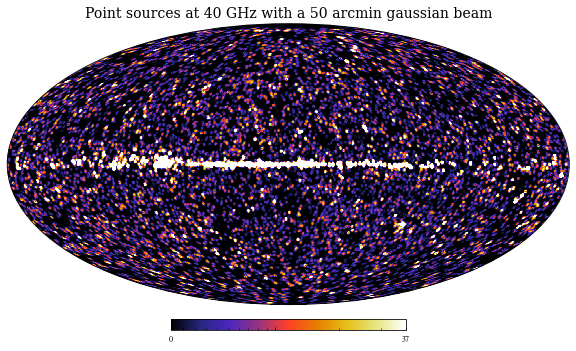

In [25]:
# Point sources seen at 40GHz over a 50 arcmin gaussian beam
simulated_emission = model.radio(30*u.GHz, fwhm=50*u.arcmin)

plot(
    simulated_emission[0], 
    title='Point sources at 40 GHz with a 50 arcmin gaussian beam', 
    norm='log', 
    cmap='CMRmap'
)